In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from numpy.random import default_rng
import matplotlib.pyplot as plt
import matplotlib
import os
import sys
from astropy.table import Table
from astropy.io import fits
import astropy.cosmology
from astropy import units as u
from astropy.coordinates import SkyCoord, Angle
import healpy as hp
from healpy.newvisufunc import projview

In [3]:
# map of number counts
NSIDE = 128
NPIX = hp.nside2npix(NSIDE)

### Load QUaia catalog

In [4]:
# clean G<20.0
quasar_fn = '/scratch/aew492/quasars/catalogs/catalog_G20.0.fits'
data_quaia = Table.read(quasar_fn, format='fits')

In [5]:
nd = len(data_quaia)
l, b = data_quaia['l'], data_quaia['b']

In [6]:
# format into healpy map
pix_idx = hp.ang2pix(NSIDE, l, b, lonlat=True)
map_data = np.bincount(pix_idx, minlength=NPIX)

In [7]:
minc = max((np.median(map_data)-np.std(map_data),0))
maxc = np.median(map_data)+1.5*np.std(map_data)

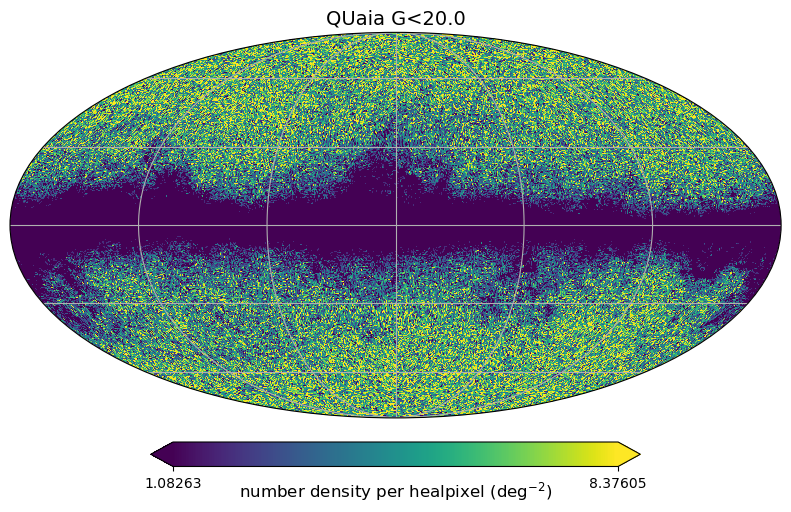

In [8]:
projview(map_data, title='QUaia G<20.0', projection_type='mollweide',
            unit=r"number density per healpixel (deg$^{-2}$)", coord=['C'], graticule=True,
        min=minc, max=maxc)

### Compute dipole

In [9]:
# fit monopole and dipole:
map_data = [float(pix) for pix in map_data]  # need to convert all entries to floats to avoid error in remove_dipole()
map_nodip, monop, dip = hp.pixelfunc.remove_dipole(map_data, fitval=True)

In [10]:
# direction
lon, lat = hp.rotator.vec2dir(dip, lonlat=True)
# amplitude
dipamp = np.linalg.norm(dip)
# create SkyCoord object
dip_quaia = SkyCoord(lon, lat, unit=u.deg, frame='galactic')

print(f"monopole: {monop:.6f}")
print(f"dipole: {dip}")
print(f"  dir ({lon:.3f}, {lat:.3f}), amplitude {dipamp:.6f}")

monopole: 3.844452
dipole: [-0.15280942 -0.18966379  0.21782923]
  dir (-128.858, 41.808), amplitude 0.326761


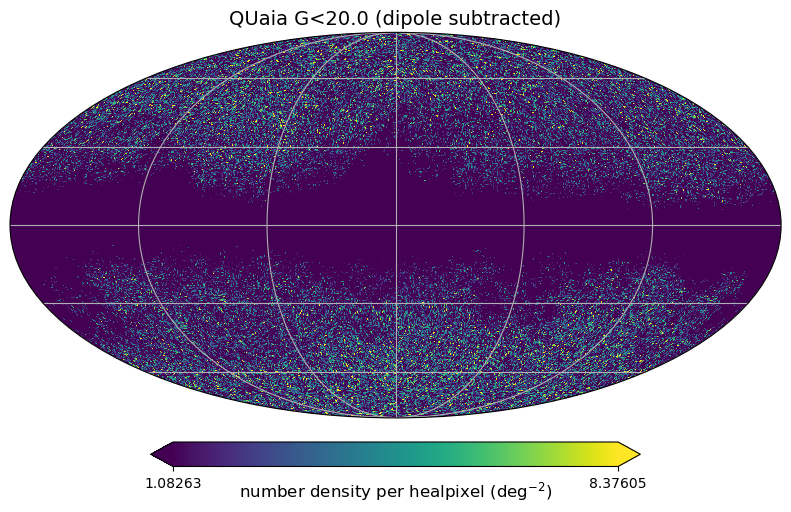

In [11]:
projview(map_nodip, title='QUaia G<20.0 (dipole subtracted)', projection_type='mollweide',
            unit=r"number density per healpixel (deg$^{-2}$)", coord=['C'], graticule=True,
        min=minc, max=maxc)

In [12]:
dip_cmb = SkyCoord(264.021, 48.253, unit=u.deg, frame='galactic')
dip_wise21 = SkyCoord(238.2, 28.8, unit=u.deg, frame='galactic')
dip_wise23 = SkyCoord(237.2, 41.8, unit=u.deg, frame='galactic')

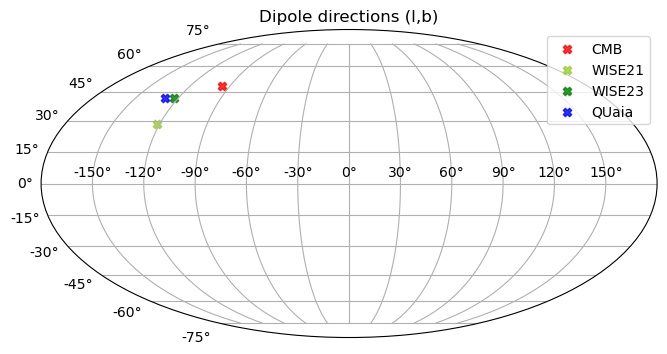

In [13]:
plt.figure(figsize=(8,4))
ax = plt.subplot(111, projection='mollweide')
plt.grid(True)

m = 'X'
plt.scatter(dip_cmb.l.wrap_at(np.pi*u.radian).to('radian'), dip_cmb.b.wrap_at(np.pi*u.radian).to('radian'),
           marker=m, c='r', alpha=0.8, label='CMB')
plt.scatter(dip_wise21.l.wrap_at(np.pi*u.radian).to('radian'), dip_wise21.b.wrap_at(np.pi*u.radian).to('radian'),
           marker=m, c='yellowgreen', alpha=0.8, label='WISE21')
plt.scatter(dip_wise23.l.wrap_at(np.pi*u.radian).to('radian'), dip_wise23.b.wrap_at(np.pi*u.radian).to('radian'),
           marker=m, c='g', alpha=0.8, label='WISE23')
plt.scatter(dip_quaia.l.wrap_at(np.pi*u.radian).to('radian'), dip_quaia.b.wrap_at(np.pi*u.radian).to('radian'),
           marker=m, c='b', alpha=0.8, label='QUaia')

plt.title('Dipole directions (l,b)')
ax.legend()

### Compare to random catalog

#### 1. Generate 3-vectors in (x,y,z)

In [14]:
rng = default_rng(seed=19)
rand_vecs = rng.normal(size=(nd,3))

#### 2. Convert $(x,y,z)\rightarrow (\mathrm{RA},\mathrm{ Dec})$

In [15]:
def xyz_to_thetaphi(xyz):
    x, y, z = xyz
    r = np.linalg.norm(xyz)
    theta = np.arctan2(y,x)
    phi = np.arccos(z/r)
    return theta, phi

def thetaphi_to_radec(theta, phi):
    ra = theta * 180/np.pi
    dec = 90 - phi * 180/np.pi
    return ra, dec

def xyz_to_radec(xyz):
    theta, phi = xyz_to_thetaphi(xyz)
    ra, dec = thetaphi_to_radec(theta, phi)
    return ra, dec

In [16]:
ra, dec = np.array([xyz_to_radec(pos) for pos in rand_vecs]).T

#### 3. Plot on the sky

In [17]:
# map of number counts
pix_idx_rand = hp.ang2pix(NSIDE, ra, dec, lonlat=True)
map_rand = np.bincount(pix_idx_rand, minlength=NPIX)

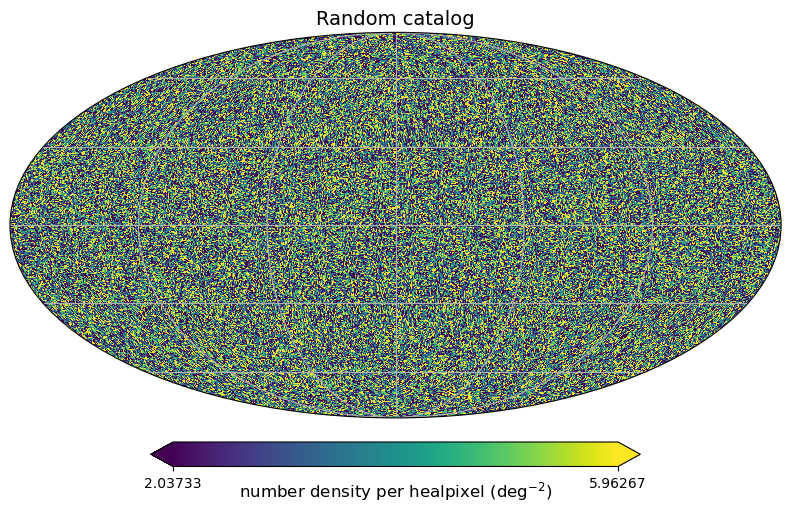

In [18]:
projview(map_rand, title='Random catalog', projection_type='mollweide',
            unit=r"number density per healpixel (deg$^{-2}$)", coord=['C'], graticule=True,
        min=np.median(map_rand)-np.std(map_rand), max=np.median(map_rand)+np.std(map_rand))

#### 4. Compute dipole

In [19]:
# fit monopole and dipole:
map_rand = [float(pix) for pix in map_rand]  # need to convert all entries to floats to avoid error in remove_dipole()
mapr_nodip, monopr, dipr = hp.pixelfunc.remove_dipole(map_rand, fitval=True)

In [20]:
# direction
lonr, latr = hp.rotator.vec2dir(dipr, lonlat=True)
# amplitude
dipampr = np.linalg.norm(dipr)
# create SkyCoord object
dip_rand = SkyCoord(lonr, latr, unit=u.deg, frame='galactic')

print(f"monopole: {monopr:.6f}")
print(f"dipole: {dipr}")
print(f"  dir ({lonr:.3f}, {latr:.3f}), amplitude {dipampr:.6f}")

monopole: 3.844452
dipole: [-0.00640519  0.00464446  0.00044501]
  dir (144.054, 3.219), amplitude 0.007924


### Compare QUaia to random results

In [21]:
# relative dipole amplitude
rel_dipamp = dipamp/dipampr
print(f"QUaia dipole is {rel_dipamp:.2f}x larger than random cat. dipole")

QUaia dipole is 41.23x larger than random cat. dipole
